In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import ifftshift, ifft2, fft2, fftshift

In [59]:
wbig = 3000
wsmall = 300
theta_grid = 0.185

extent = np.array((-1, 1, -1, 1))

zbig = np.linspace(-1,1, wbig)
xbig, ybig = np.meshgrid(zbig, zbig)

zsmall = np.linspace(-1,1, wsmall)
xsmall, ysmall = np.meshgrid(zsmall, zsmall)

def beam(xy, x0, y0, s, p):
    x, y = xy
    r2 = (x-x0)**2 + (y-y0)**2
    g = np.exp(-(r2/(2*s**2))**p)
    return g.ravel()
    
def cross(xy, s, theta):
    x, y = xy
    rx = np.cos(theta)*x - np.sin(theta)*y
    ry = np.sin(theta)*x + np.cos(theta)*y
    return np.exp(-0.5*(rx/s)**2) + np.exp(-0.5*(ry/s)**2)

def signal(xy, a0, r0, th0, dr, dth):
    x, y = xy
    r = (x**2 + y**2)**0.5 - r0
    th = (np.arctan2(y, x) - th0 + (np.pi/2)) % np.pi - (np.pi/2)
    g = a0 * np.exp(-0.5*( (r/dr)**2 + (th/dth)**2))
    return g.ravel()

model = lambda s, p: lambda xy, x0, y0, a: a * beam(xy, x0, y0, s, p)
model0 = model(1/3, 1)
model1 = model(1/3, 4)
model2 = model(1/5, 2)

In [3]:
photo_dir = './photos/'
photo_paths = os.listdir(photo_dir)
photos_original = [
    plt.imread(photo_dir + path, format='jpeg')[:,500:500+wbig]
    for path in photo_paths
]
photos = [
    photo_original[:,:,1] / 255
    for photo_original in photos_original
]

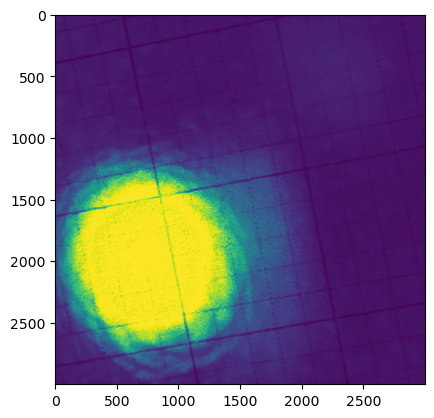

In [4]:
photo_mean = np.mean(np.array(photos)**0.5, axis=0)**2
photo_mean_small = photo_mean[::10, ::10]
plt.imshow(photo_mean)

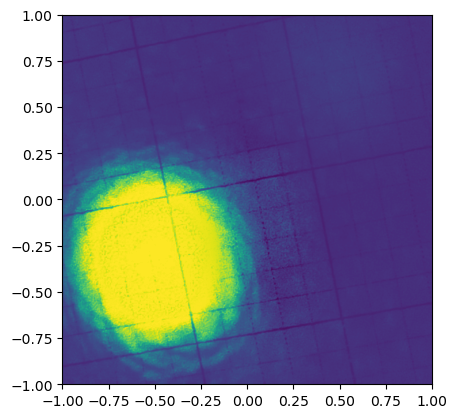

In [65]:
(x0, y0, a0), cov = sp.optimize.curve_fit(
    model0, (2.2*(xsmall*np.cos(theta_grid) - ysmall*np.sin(theta_grid)),ysmall*np.cos(theta_grid) + xsmall*np.sin(theta_grid)), photo_mean_small.flatten(),
    p0=[0.1,0.1,0.1], 
    bounds=([0.1,-1.5,0], [0.2,1.5,0.25])
)
photo_mean0 = photo_mean - model0((2.2*(xbig*np.cos(theta_grid) - ybig*np.sin(theta_grid)),ybig*np.cos(theta_grid) + xbig*np.sin(theta_grid)), x0, y0, a0).reshape(wbig, wbig)
photo_mean0_small = photo_mean0[::10, ::10]
plt.imshow(photo_mean0, extent=extent)

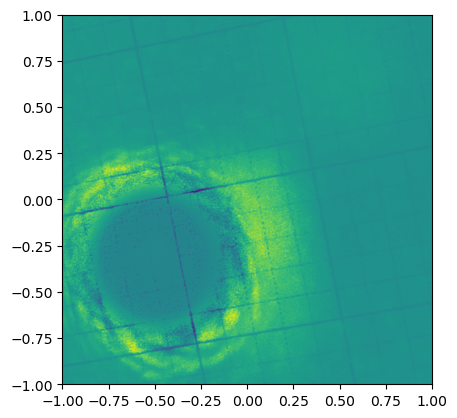

In [45]:
(x1, y1, a1), cov = sp.optimize.curve_fit(
    model1, (xsmall,ysmall), photo_mean_small.flatten(),
    p0=[0.1,0.1,0.8], 
    bounds=([-1.5,-1.5,0.5], [1.5,1.5,1])
)
photo_mean1 = photo_mean - model1((xbig, ybig), x1, y1, a1).reshape(wbig, wbig)
plt.imshow(photo_mean1, extent=extent)

In [66]:
photos_small = [
    (photo[::10,::10] - photo_mean0_small) for photo in photos
]

beam_pos = []
photos_fit = []
for (i, photo) in enumerate(photos):

    photo_small = photos_small[i]
    x20 = zsmall[np.argmax(np.sum(photo_small, axis=0))]
    y20 = zsmall[np.argmax(np.sum(photo_small, axis=1))]
    (x2, y2, a2), cov = sp.optimize.curve_fit(
        model2, (xsmall,ysmall), photo_small.flatten(),
        p0=(x20, y20, 0.3), 
        bounds=([x20-0.1, y20-0.1, 0.1], [x20+0.1, y20+0.1, 0.5]),
        max_nfev=500
    )
    beam_pos.append((x2, y2))

    photo_fit = photo - photo_mean0 - model2((xbig,ybig), x2, y2, a2).reshape(wbig, wbig)
    
    photos_fit.append(photo_fit)
    print(i, end=',')

0,1,2,3,4,5,6,7,8,9,

In [67]:
beam_pos = np.array(beam_pos)
sort = np.argsort(beam_pos[:,1])

In [68]:
ffts = [
    fftshift(fft2(ifftshift(photo_fit))) for photo_fit in photos_fit
]

In [69]:
mask = (
    100*beam((xbig,ybig), 0, 0, s=2e-3,p=0.5).reshape(wbig, wbig)
    + 10*(1 - beam((xbig,ybig), 0, 0, s=4e-2,p=6)).reshape(wbig, wbig)
    + 10*cross((xbig, ybig), 6e-4, theta_grid) # grid
    + 0.15*cross((xbig, ybig), 8e-4, 0) # ringing artifacts
    + 0.15
    + 10*(1- np.exp(-0.5*(ybig/0.05)**4))
)

ffts_clean = [ np.clip(
    abs(fft)*1e-4 - mask
, 0, 100)[ (wbig-wsmall)//2:(wbig+wsmall)//2, (wbig-wsmall)//2:(wbig+wsmall)//2 ] for fft in ffts ]

cleans = [
    fftshift(ifft2(ifftshift(clean))) for clean in ffts_clean
]

In [70]:
params = []
for (i, fft_clean) in enumerate(ffts_clean):
    x_est = zsmall[np.argmax(np.sum(fft_clean, axis=0))]
    y_est = zsmall[np.argmax(np.sum(fft_clean, axis=1))]
    r_est = (x_est**2 + y_est**2)**(0.5)
    th_est = np.arctan(y_est/x_est)
    param, cov =  sp.optimize.curve_fit(
        signal, (xsmall, ysmall), fft_clean.flatten(),
        p0 = [0.1, r_est, th_est, 0.05, 0.05],
        bounds = ([0, 0, -np.pi/2, 0, 0], [1, 0.5, np.pi/2, 0.1, 0.1])
    )
    if param[0] < 0.05:
        param[0] = 0
    params.append(param)
    print(i, end=',')

0,1,2,3,4,5,6,7,8,9,

In [71]:
ffts_fit = [
    signal((xsmall, ysmall), *param).reshape(wsmall, wsmall) for param in params
]
fits = [
    fftshift(ifft2(ifftshift(fft_fit))) for fft_fit in ffts_fit
]

In [72]:
theta = [ param[2] for param in params ] 
rots = [sp.ndimage.rotate(photo_fit, theta[i]*180/np.pi) for (i, photo_fit) in enumerate(photos_fit)]

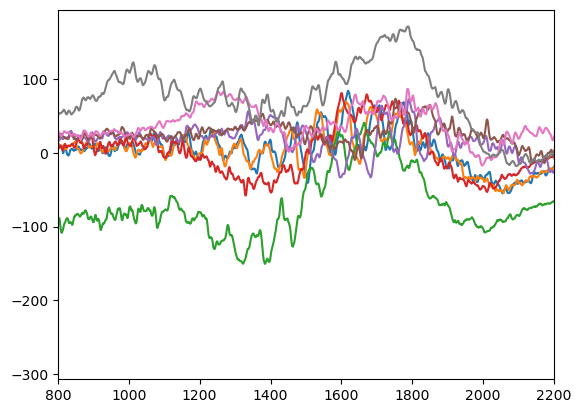

In [73]:
for (i, j) in enumerate(sort[2:]):
    plt.plot(np.sum(rots[j], axis=0))
plt.xlim(800,2200)
plt.savefig('stacked.png')

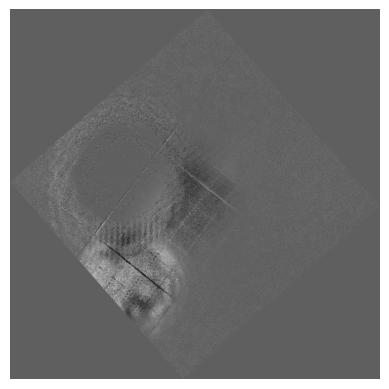

In [74]:
for (i, j) in enumerate(sort[2:]):
    plt.imshow(rots[j], cmap='gray')
    plt.axis('off')
    plt.savefig(f'./cleaned/{i:02}.png', bbox_inches='tight', pad_inches=0)

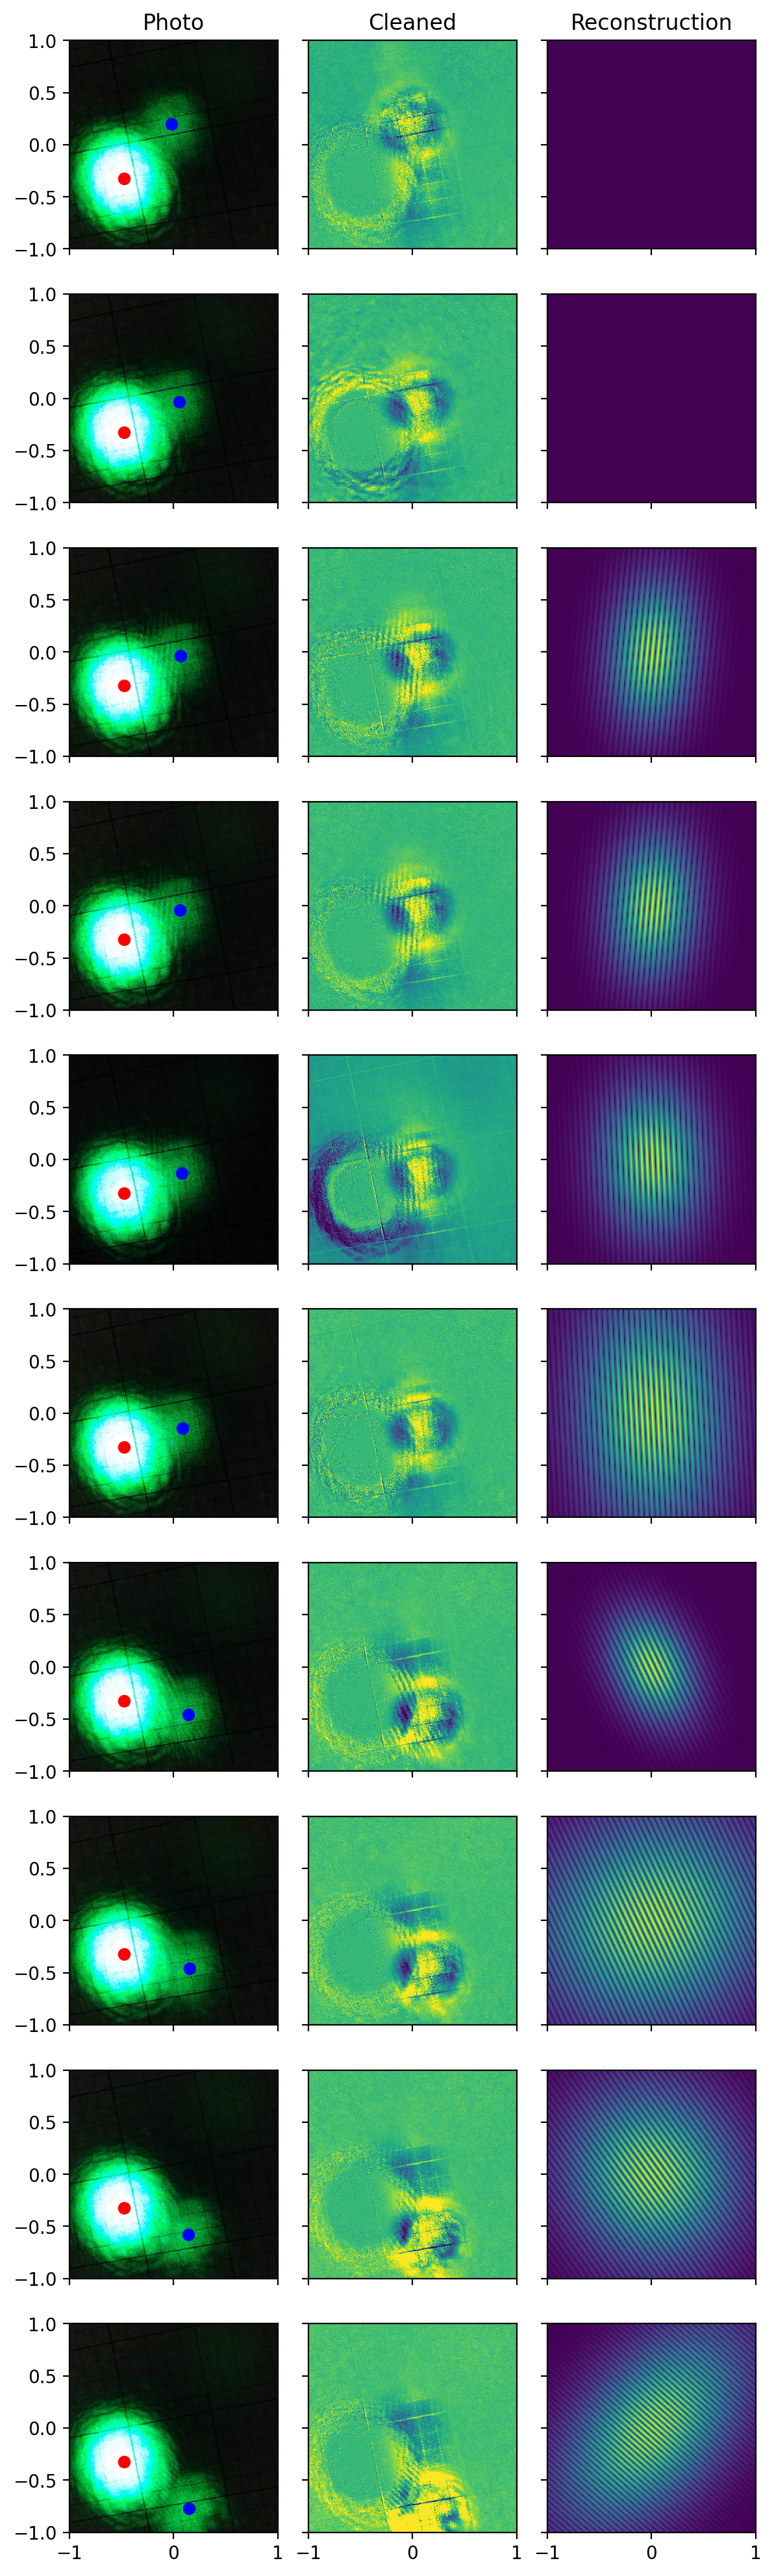

In [76]:
fig, axs = plt.subplots(
    nrows=len(fits), ncols=3, 
    figsize=(6, 2*len(fits)),
    dpi=200,
    sharex=True, sharey=True,
)
plt.xlim(-1,1)
plt.ylim(-1,1)
axs[0][0].set_title('Photo')
axs[0][1].set_title('Cleaned')
axs[0][2].set_title('Reconstruction')
for (i, fit) in enumerate(fits):
    # plt.imshow(photos_small[i], extent=extent)
    # plt.show()
    j = sort[i]
    axs[i][0].imshow(photos_original[j], extent=extent)
    axs[i][0].scatter(x1, -y1, color='red')
    x2, y2 = beam_pos[j]
    axs[i][0].scatter(x2, -y2, color='blue')
    axs[i][1].imshow(photos_fit[j], extent=extent, vmin=-0.2, vmax=0.1)
    axs[i][2].imshow(abs(fits[j]), extent=2*extent)

    # plt.imshow(ffts_clean[i], extent=extent)
    # plt.show()
    # plt.imshow(fits[i], extent=extent)
    # plt.show()
    # plt.imshow(abs(fftshift(ifft2(ifftshift(fits[i])))))
    # plt.xlim(-0.5, 0.5)
    # plt.ylim(-0.5, 0.5)
    # plt.show()

plt.tight_layout()
plt.savefig('main.png')